# CIS-520 Project -[What's cooking](https://www.kaggle.com/c/whats-cooking-kernels-only)

* This notebook looks at the Kaggle contest *What's cooking*. We tackle a supervised and unsupervised learning problem using this dataset
* The inputs are a collection of words and hence a key aspect of this problem is to convert the collection of words into a finite dimensional feature

In [1]:
## Run once only, restart the runtime and run the next cell to verify
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.22
!pip freeze | grep scikit

Uninstalling scikit-learn-0.22:
  Successfully uninstalled scikit-learn-0.22
  Using cached https://files.pythonhosted.org/packages/2e/d0/860c4f6a7027e00acff373d9f5327f4ae3ed5872234b3cbdd7bcb52e5eff/scikit_learn-0.22-cp36-cp36m-manylinux1_x86_64.whl
scikit-image==0.15.0
scikit-learn==0.22


In [2]:
pip show scikit-learn

Name: scikit-learn
Version: 0.22
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: joblib, numpy, scipy
Required-by: yellowbrick, umap-learn, textgenrnn, sklearn, sklearn-pandas, mlxtend, lucid, lightgbm, librosa, imbalanced-learn, fancyimpute


In [0]:
import numpy as np
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import json
import unicodedata
import re
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# from pywaffle import Waffle

In [4]:
!wget https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/test.json
!wget https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/train.json

--2019-12-11 02:35:54--  https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/test.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2844086 (2.7M) [text/plain]
Saving to: ‘test.json.1’

test.json.1         100%[===================>]   2.71M  --.-KB/s    in 0.1s    

2019-12-11 02:35:56 (24.4 MB/s) - ‘test.json.1’ saved [2844086/2844086]

--2019-12-11 02:35:57--  https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12415067 (12M) [text/plain]
Sav

# Loading dataset
We load the dataset and display a single entry from this dataset

In [0]:
with open("test.json", "r") as f:
    test_data = json.load(f)
with open("train.json", "r") as f:
    train_data = json.load(f)
train_data_df = pd.DataFrame(train_data)
test_data_df = pd.DataFrame(test_data)

Example from dataset

In [6]:
train_data[0]

{'cuisine': 'greek',
 'id': 10259,
 'ingredients': ['romaine lettuce',
  'black olives',
  'grape tomatoes',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo beans',
  'feta cheese crumbles']}

# Data analysis and Visualization

The aim of this analysis is as follows:

* Gain an understanding of the dataset, distribution of labels and number of data points. 
* Look for potentially useful features that can help an classifier achieve higher accuracies.
* Look for anamolies in data that need to be handled through data pre-processing and cleaning. 

### Preliminary Understanding of Data

In [7]:
train_data_df = pd.DataFrame(train_data)
test_data_df = pd.DataFrame(test_data)
cuisines = train_data_df["cuisine"].unique()
print("Data size: " + str(train_data_df.shape))
print("Number of cuisines: ", str(len(cuisines)))

Data size: (39774, 3)
Number of cuisines:  20


We see that the data is imbalanced among the 20 classes

In [8]:
train_data_df.groupby(by='cuisine').count().sort_values(by='ingredients',ascending=False)

,id,ingredients
cuisine,,
italian,7838,7838
mexican,6438,6438
southern_us,4320,4320
indian,3003,3003
chinese,2673,2673
french,2646,2646
cajun_creole,1546,1546
thai,1539,1539
japanese,1423,1423


In [9]:
print(train_data_df.head())

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...


In [0]:
def get_ingredients(cuisine_val):
    """
    Get all the ingredients for a particular cuisine
    """
    text = ''
    for i in range(train_data_df.shape[0]):
        if cuisine_val == train_data_df.iloc[i, 1]:
            text = text + " " + ' '.join(train_data_df.iloc[i, 2])
    return text
    
def get_num_ingredients(cuisine_val):
    """
    Get the number of ingredients of each recipe for a particular cuisine
    """
    num = []
    for i in range(train_data_df.shape[0]):
        if cuisine_val == train_data_df.iloc[i, 1]:
            num.append(len(train_data_df.iloc[i,2]))
    return num

def plot_word_cloud(txt, coloc=True):
    """
    Plot the word cloud corresponding to some text
    """
    wordcloud = WordCloud(background_color="white", collocations=coloc).generate(txt)
    plt.figure(figsize = (7, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Pre-processing

In [0]:
def create_train_test_data(train_data_df, test_data_df):
  """
  Splits the original training and test data
  """
  train_recepies = [] 
  train_targets = []
  for ig_item in train_data_df['ingredients']:
      train_recepies.append(ig_item)
  for cuisine_item in train_data_df['cuisine']:
      train_targets.append(cuisine_item)

  # create test data only, no targets
  test_recepies = []
  for ig_item in test_data_df['ingredients']:
      test_recepies.append(ig_item)
  return train_recepies, train_targets, test_recepies

In [12]:
train_features, train_targets, test_features = create_train_test_data(train_data_df, test_data_df)
print(train_targets[0:5])

['greek', 'southern_us', 'filipino', 'indian', 'indian']


#### Remove small receipies, special characters, quantity classifiers (inch, oz etc.)

This is the key-preprocessing function. The data is processed to contain only lower case alphabets and spaces. Additional features are added based on number of ingredients/characters/occurrence of special characters etc.


In [13]:
def process_features(features, targets, mode="train"):
    processed_recipe = []
    processed_cuisine = []
    count_len = 0

    for idx, recipe in enumerate(features):
        processed_ingredient = []

        # Convert to lower case
        if mode=='train':
            cuisine_lower = targets[idx].lower()

        cur_features = {}
        ingredient_all = ' '.join(recipe)

        # f1) Add feature for number of ingredients
        if len(recipe) <= 2:
            count_len += 1
            continue
        cur_features["num_ingredients"] = len(recipe)

        # f2) Change accented characters to ascii characters
        accented_char_set= ["â", "ç", "è", "é", "í", "î", "ú", "’"]
        cur_features["accented"] = 0
        if 1 in [c in ingredient_all for c in accented_char_set]:
            cur_features["accented"] = 1

        # f3) Add feature for measurement units
        measurement_words = ["pound", "kg", "lb", "oz", "ounc", "inch"]
        cur_features["measurement"] = 0
        if np.any([w in ingredient_all for w in measurement_words]):
            cur_features["measurement"] = 1

        # f4) Symbols
        cur_features["symbol"] = 0
        if ("™" in ingredient_all) or ("®" in ingredient_all) or ("!" in ingredient_all):
            cur_features["symbol"] = 1

        # f5) Feature for numbers
        cur_features["number"] = 0
        if any(char.isdigit() for char in ingredient_all):
            cur_features["number"] = 1
            
        # f6) Feature for percentage
        cur_features["percentage"] = 0
        if "%" in ingredient_all:
            cur_features["percentage"] = 1

        # p1) Convert to lower case
        ingredient_all = ingredient_all.lower()
        # p2) Change accented characters to ascii characters
        ingredient_all = unicodedata.normalize('NFD', ingredient_all).encode('ascii', 'ignore')
        ingredient_all = ingredient_all.decode('ascii')
        # p3) Remove measurement units
        ingredient_all = re.sub((r'\b(pound|kg|lb|oz|ounc|inch)\b'), ' ', ingredient_all) 
        # p4) Remove symbol
        ingredient_all = ingredient_all.replace("!", " ")
        ingredient_all = ingredient_all.replace("™", " ")
        ingredient_all = ingredient_all.replace("®", " ")
        # p5) Remove brackets
        ingredient_all = ingredient_all.replace("(", " ")
        ingredient_all = ingredient_all.replace(")", " ")
        # p6) Remove hyphens
        ingredient_all = ingredient_all.replace("-", " ")
        # p7) Remove numbers
        ingredient_all = re.sub("\d", " ", ingredient_all)
        # p8) Remove percentages and / (occur with numbers)
        ingredient_all = ingredient_all.replace("/", " ")
        ingredient_all = ingredient_all.replace("%", " ")

        # p9) Remove some more characters
        ingredient_all = ingredient_all.replace(".", " ")
        ingredient_all = ingredient_all.replace("€", " ")
        ingredient_all = ingredient_all.replace(",", " ")

        # p10) Handle apostrophe
        ingredient_all = ingredient_all.replace("’", "'")
        ingredient_all = ingredient_all.replace("'", "")

        # p11) Replace & with and
        ingredient_all = ingredient_all.replace("&", "and")

        ings = ' '.join(ingredient_all.split())
        cur_features["num_words"] = len(ingredient_all.split())

        processed_recipe.append((
                cur_features["num_words"], cur_features["num_ingredients"],
                cur_features["accented"], cur_features["measurement"],
                cur_features["symbol"], cur_features["number"],
                cur_features["percentage"], ings
            ))
        if mode=='train':
            processed_cuisine.append(cuisine_lower)
    
    print('Removed {} small recipe from input data'.format(count_len))
    if mode=='train':
        return processed_recipe, processed_cuisine
    else:
        return processed_recipe

processed_train_features, processed_train_target = process_features(train_features, train_targets, mode='train')
processed_test_features = process_features(test_features, train_targets,  mode='test') # just passing the targets, not using it while preprocessing test data


print(len(processed_train_target))
print(len(processed_train_features))

Removed 215 small recipe from input data
Removed 56 small recipe from input data
39559
39559


The below looks at the character set after pre-processing

In [14]:
# The only characters that remain in representation are characters
txt = []
for i in range(len(processed_train_features)):
    txt.append(processed_train_features[i][-1])
print(' '.join(sorted(set(' '.join(txt)))))

  a b c d e f g h i j k l m n o p q r s t u v w x y z


We next look at the feature set we have created

In [15]:
train_data = pd.DataFrame(processed_train_features)
test_data = pd.DataFrame(processed_test_features)

train_data.columns = ["num_words", "num_ingredients", "accented", "measurement", "symbol", "number", "percentage", "text"]
print(train_data.shape)

(39559, 8)


In [16]:
train_data.describe()

,num_words,num_ingredients,accented,measurement,symbol,number,percentage
count,39559.000000,39559.000000,39559.000000,39559.000000,39559.000000,39559.00000,39559.000000
mean,20.673955,10.815921,0.014586,0.084709,0.004651,0.00905,0.007938
std,8.919131,4.392268,0.119889,0.278452,0.068042,0.09470,0.088740
min,3.000000,3.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,14.000000,8.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,20.000000,10.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,26.000000,13.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,141.000000,65.000000,1.000000,1.000000,1.000000,1.00000,1.000000


## Feature engineering: Binarize textual recepies/features

Below are the two functions that we use to build the features. The first is use to generate bag od words and the second is the TF-IDF based featurizer. Some key hyper-parameters are:
* min_df = 0.99 -> remove any word which is occuring in less than 0.3% of samples
* ngram_range -> Range of n-grams to consider
* smooth_idf -> Smoothing factor of 1 when calculating counts
* sublinear -> Takes the log of idf
* Binary -> Instead of counting number of occurences, have a binary indicator for presence or absence of word

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def generate_bag_of_words(train_bin_vec, test_bin_vec):
    binarizer = CountVectorizer(analyzer = "word",  ngram_range = (1, 2), 
                                binary = False, tokenizer = None, preprocessor = None, 
                                stop_words = None,  min_df=0.001) 
    binarizer.fit([str(i[-1]) for i in train_bin_vec])
    binary_vector_tr = binarizer.transform([str(i[-1]) for i in train_bin_vec])
    binary_vector_te = binarizer.transform([str(i[-1]) for i in test_bin_vec])
    return binary_vector_tr, binary_vector_te, binarizer

def generate_tf_idf(train_bin_vec, test_bin_vec, bin=False, ngrammax=2,
                    use_idf=True, smooth_idf=True, sublinear_tf=False,
                    mindf=0.001):
    vectorizer = TfidfVectorizer(input="content", preprocessor=None, tokenizer=None, 
                                 analyzer="word", ngram_range=(1, ngrammax), min_df=mindf,
                                 binary=bin, norm="l2", use_idf=use_idf, smooth_idf=smooth_idf,
                                 sublinear_tf=sublinear_tf)
    vectorizer.fit([str(i[-1]) for i in train_bin_vec])
    binary_vector_tr = vectorizer.transform([str(i[-1]) for i in train_bin_vec])
    binary_vector_te = vectorizer.transform([str(i[-1]) for i in test_bin_vec])
    return binary_vector_tr, binary_vector_te, vectorizer


As you can see, the vocabulary is manageable and is around 1401pl

In [18]:
train_rep, test_rep, binarizer = generate_bag_of_words(processed_train_features, processed_test_features)
print(train_rep.shape)

(39559, 3447)


In [19]:
sorted(list(binarizer.vocabulary_.keys()))[0:10]

['active',
 'active dry',
 'added',
 'adobo',
 'adobo sauce',
 'agave',
 'agave nectar',
 'alfredo',
 'alfredo sauce',
 'all']

In [0]:
from scipy import interp
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from pdb import set_trace as debug
from sklearn import preprocessing
from sklearn.svm import SVC, LinearSVC
from matplotlib import colors


def compute_metric(y_test, y_pred, n_classes=20):

  # Compute ROC curve and ROC area for macro and micro ovo
  print(y_test.shape)
  print(y_pred.shape)
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  # debug()
  lw = 2
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])
  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot weighted Micro ROC curves
  # https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

  plt.figure()
  # fig = plt.figure()
  ax = plt.subplot(111)

  # plt.plot(fpr["micro"], tpr["micro"],
  #         label='micro-average ROC curve (area = {0:0.2f})'
  #               ''.format(roc_auc["micro"]),
  #         color='deeppink', linestyle=':', linewidth=4)

  # plt.plot(fpr["macro"], tpr["macro"],
  #         label='macro-average ROC curve (area = {0:0.2f})'
  #               ''.format(roc_auc["macro"]),
  #         color='navy', linestyle=':', linewidth=4)
  
  NUM_COLORS = 20

  color_list = []
  cm = plt.get_cmap('gist_rainbow')
  for i in range(NUM_COLORS):
      color_list.append((colors.to_rgb(cm(i//3*3.0/NUM_COLORS))))

  for i, color in zip(range(n_classes), color_list):
    ax.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 1.3, box.height])

  # Put a legend to the right of the current axis
  # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  # ax.legend(loc='upper right', bbox_to_anchor=(0.5, 0.5))
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True)


  # plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('MultiClass ROC-extension', loc='left', pad=30)
  plt.legend(loc="lower right")
  plt.show()

  
  try:
    weighted_roc_auc_ovo = roc_auc_score(y_test, y_pred, multi_class="ovo",
                                     average="weighted")
    macro_roc_auc_ovo = roc_auc_score(y_test, y_pred, multi_class="ovo",
                                  average="macro")
  except:
    debug()


  return macro_roc_auc_ovo, weighted_roc_auc_ovo
 

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


def train(train_binary_vector, processed_train_target, cross_val=True, confusion=True, roc=True):
    lb_en = LabelEncoder()
    processed_train_target_encoded = lb_en.fit_transform(processed_train_target)
    decoded_lb = lb_en.inverse_transform([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
    index = list(decoded_lb)
    columns = list(decoded_lb)
    
    X_train, X_test, y_train, y_test = train_test_split(train_binary_vector, processed_train_target_encoded , random_state = 0)
    classifiers = []
    
    log_reg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
    
    classifiers = {"Logistic" :log_reg}


    for cl in classifiers:
        print(cl)
        mod = classifiers[cl]
    
        X , X_test, y, y_test = train_test_split(X_train, y_train, test_size=0.20)
    
        mod.fit(X, y)
        print('Logistic Classifier LogLoss {score}'.format(score=log_loss(y, mod.predict_proba(X))))
        print('Logistic Classifier Accuracy {score}'.format(score=accuracy_score(y, mod.predict(X))))
        print('Logistic Classifier Accuracy {score}'.format(score=accuracy_score(y_test, mod.predict(X_test))))
    
        if confusion:
            y_pred = mod.predict(X_test)
            conf_mat = confusion_matrix(y_test, y_pred)
            cm_df = pd.DataFrame(conf_mat,columns,index)
            plt.figure(figsize=(10,6))
            sns.heatmap(cm_df, annot=True,  fmt="d")
            plt.show()
        
        if roc:
          enc = preprocessing.OneHotEncoder()
          enc.fit(np.asarray(y_test).reshape(-1, 1))
          y_test_one_hot = enc.transform(np.asarray(y_test).reshape(-1, 1)).toarray()
          y_pred_proba = mod.predict_proba(X_test)

          macro_roc_auc_ovo, weighted_roc_auc_ovo = compute_metric(y_test_one_hot, y_pred_proba, n_classes=20)
          print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} " "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))

    
        if cross_val:
            scores = cross_val_score(mod, X_train, y_train, cv=5)
            print(scores)
            print(np.mean(scores))
        print("-----")
    

## Logistic Regression: Final model after search of parameters

Logistic
Logistic Classifier LogLoss 0.6734598282573379
Logistic Classifier Accuracy 0.8225405519275332
Logistic Classifier Accuracy 0.7716548702392989


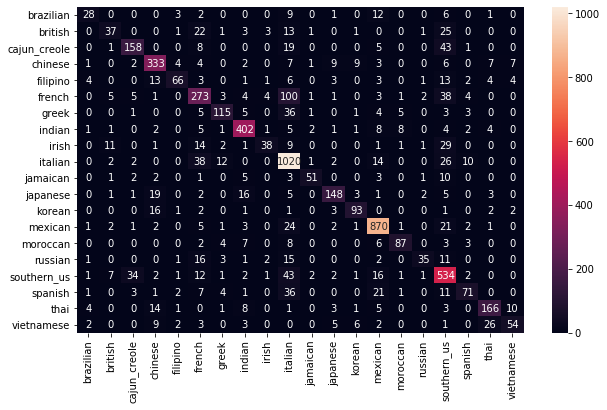

(5934, 20)
(5934, 20)


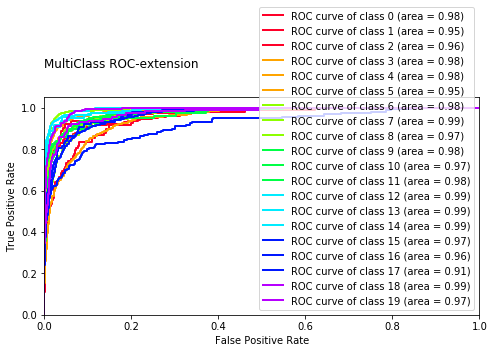

One-vs-One ROC AUC scores:
0.972130 (macro),
0.974624 (weighted by prevalence)
-----


In [22]:
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=1, use_idf=True, smooth_idf=True,
                                                 sublinear_tf=False, mindf=0.0001)

train(train_rep, processed_train_target, False, True)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from pdb import set_trace as debug
from sklearn import preprocessing
from sklearn.svm import SVC, LinearSVC
from matplotlib import colors


In [0]:


def train_custom_svm(train_binary_vector, processed_train_target, mod, cross_val=True, confusion=True):
    lb_en = LabelEncoder()
    processed_train_target_encoded = lb_en.fit_transform(processed_train_target)
    decoded_lb = lb_en.inverse_transform([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
    index = list(decoded_lb)
    columns = list(decoded_lb)

    X_train, X_test, y_train, y_test = train_test_split(train_binary_vector, processed_train_target_encoded , random_state = 0)
    classifiers = []    
    X , X_test, y, y_test = train_test_split(X_train, y_train, test_size=0.20)
    mod.fit(X, y)
    # print('RFC LogLoss {score}'.format(score=log_loss(y, mod.predict_proba(X))))
    print('RFC Accuracy {score}'.format(score=accuracy_score(y, mod.predict(X))))
    print('RFC Accuracy {score}'.format(score=accuracy_score(y_test, mod.predict(X_test))))

    if confusion:
        y_pred = mod.predict(X_test)
        conf_mat = confusion_matrix(y_test, y_pred)
        cm_df = pd.DataFrame(conf_mat,columns,index)
        plt.figure(figsize=(10,6))
        sns.heatmap(cm_df, annot=True,  fmt="d")
        plt.show()
        
        enc = preprocessing.OneHotEncoder()
        enc.fit(np.asarray(y_test).reshape(-1, 1))
        y_test_one_hot = enc.transform(np.asarray(y_test).reshape(-1, 1)).toarray()
        y_pred_proba = mod.predict_proba(X_test)

        macro_roc_auc_ovo, weighted_roc_auc_ovo = compute_metric(y_test_one_hot, y_pred_proba, n_classes=20)
        print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} " "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))


    if cross_val:
        scores = cross_val_score(mod, X_train, y_train, cv=5)
        print(scores)
        print(np.mean(scores))
    print("-----")

    





# Training final model: SVM

RFC Accuracy 0.9999157362544765
RFC Accuracy 0.8003033367037411


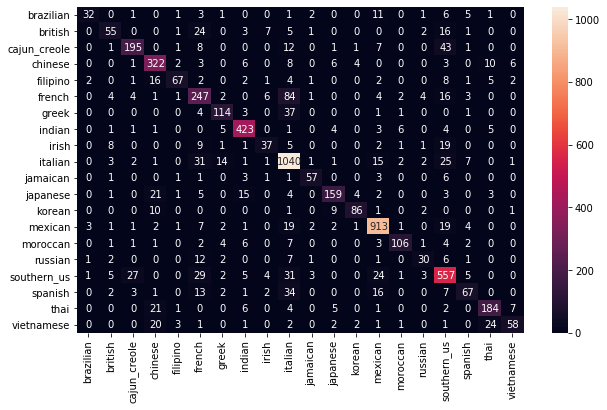

(5934, 20)
(5934, 20)


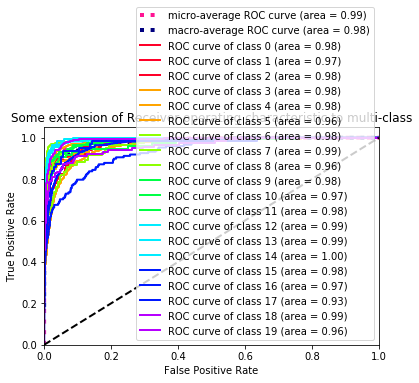

One-vs-One ROC AUC scores:
0.976939 (macro),
0.979901 (weighted by prevalence)
-----


In [0]:
model = SVC(C=1000.0,
            kernel='rbf', 
            gamma='scale',
             shrinking=True,
            probability=True,
            decision_function_shape='ovo', 
            class_weight='balanced')
train_custom_svm(train_rep, processed_train_target, model, False, True)
